In [26]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# from prophet import Prophet
from fbprophet import Prophet
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast import GridGenerator
from scalecast.notebook import tune_test_forecast
# import prophet

In [27]:
# read in data
data = pd.read_csv('csv/daily-website-visitors.csv',parse_dates = ['Date'], thousands=',')

In [28]:
# set graph sizes
sns.set(rc={'figure.figsize':(30,15)})

In [29]:
data.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,2014-09-14,2146,1582,1430,152
1,2,Monday,2,2014-09-15,3621,2528,2297,231
2,3,Tuesday,3,2014-09-16,3698,2630,2352,278
3,4,Wednesday,4,2014-09-17,3667,2614,2327,287
4,5,Thursday,5,2014-09-18,3316,2366,2130,236


In [30]:
# the dataset is in sequential order
data = data.sort_values('Date')

In [31]:
data.drop(['Row'],axis=1).describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Day,2167,7,Wednesday,310,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Day.Of.Week,2167.0,NaN,NaN,NaN,NaT,NaT,3.997231,2.000229,1.0,2.0,4.0,6.0,7.0
Date,2167,2167,2014-01-10 00:00:00,1,2014-01-10,2020-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Page.Loads,2167.0,NaN,NaN,NaN,NaT,NaT,4116.989386,1350.977843,1002.0,3114.5,4106.0,5020.5,7984.0
Unique.Visits,2167.0,NaN,NaN,NaN,NaT,NaT,2943.646516,977.886472,667.0,2226.0,2914.0,3667.5,5541.0
First.Time.Visits,2167.0,NaN,NaN,NaN,NaT,NaT,2431.824181,828.704688,522.0,1830.0,2400.0,3038.0,4616.0
Returning.Visits,2167.0,NaN,NaN,NaN,NaT,NaT,511.822335,168.73637,133.0,388.5,509.0,626.5,1036.0


In [32]:
#Let’s load the series we want to predict, Unique Visits, into a Forecaster object:
f = Forecaster(y=data['Unique.Visits'],current_dates=data['Date'])
f

Forecaster(
    DateStartActuals=2014-01-10T00:00:00.000000000
    DateEndActuals=2020-12-08T00:00:00.000000000
    Freq=None
    N_actuals=2167
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

In [33]:
#This shows we have 2,167 daily observations from 9/14/2014 through 8/19/2020 to forecast with.
#The first thing we should do after initializing the object is set its test length. We can choose a number of observations to use by passing an int to the function below,
#or split the data fractionally by passing a float between 0 and 1.
f.set_test_length(.2)

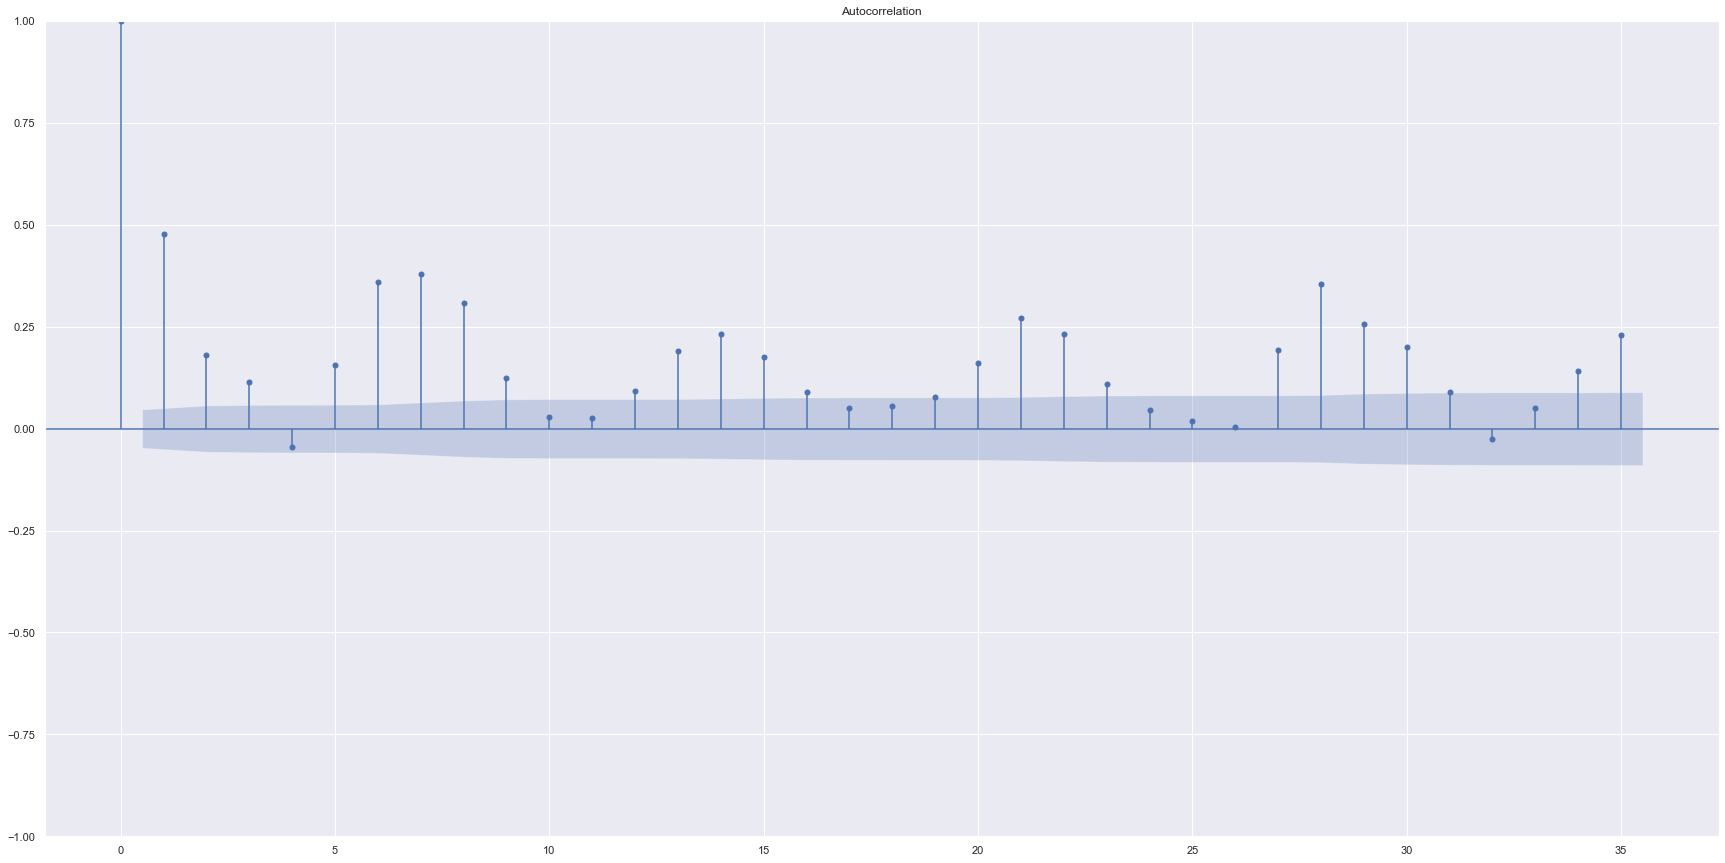

In [34]:
#Before beginning the forecasting process, we should get a better idea of the signals within the time series itself. 
#Using ACF, PACF, and Periodogram plots, we can observe how the series is auto-correlated. We can leave the test set out of all visualizations (train_only=True) 
#to not leak data when making decisions about which signals exist in the data.
f.plot_acf(train_only=True,lags=35)
plt.show()

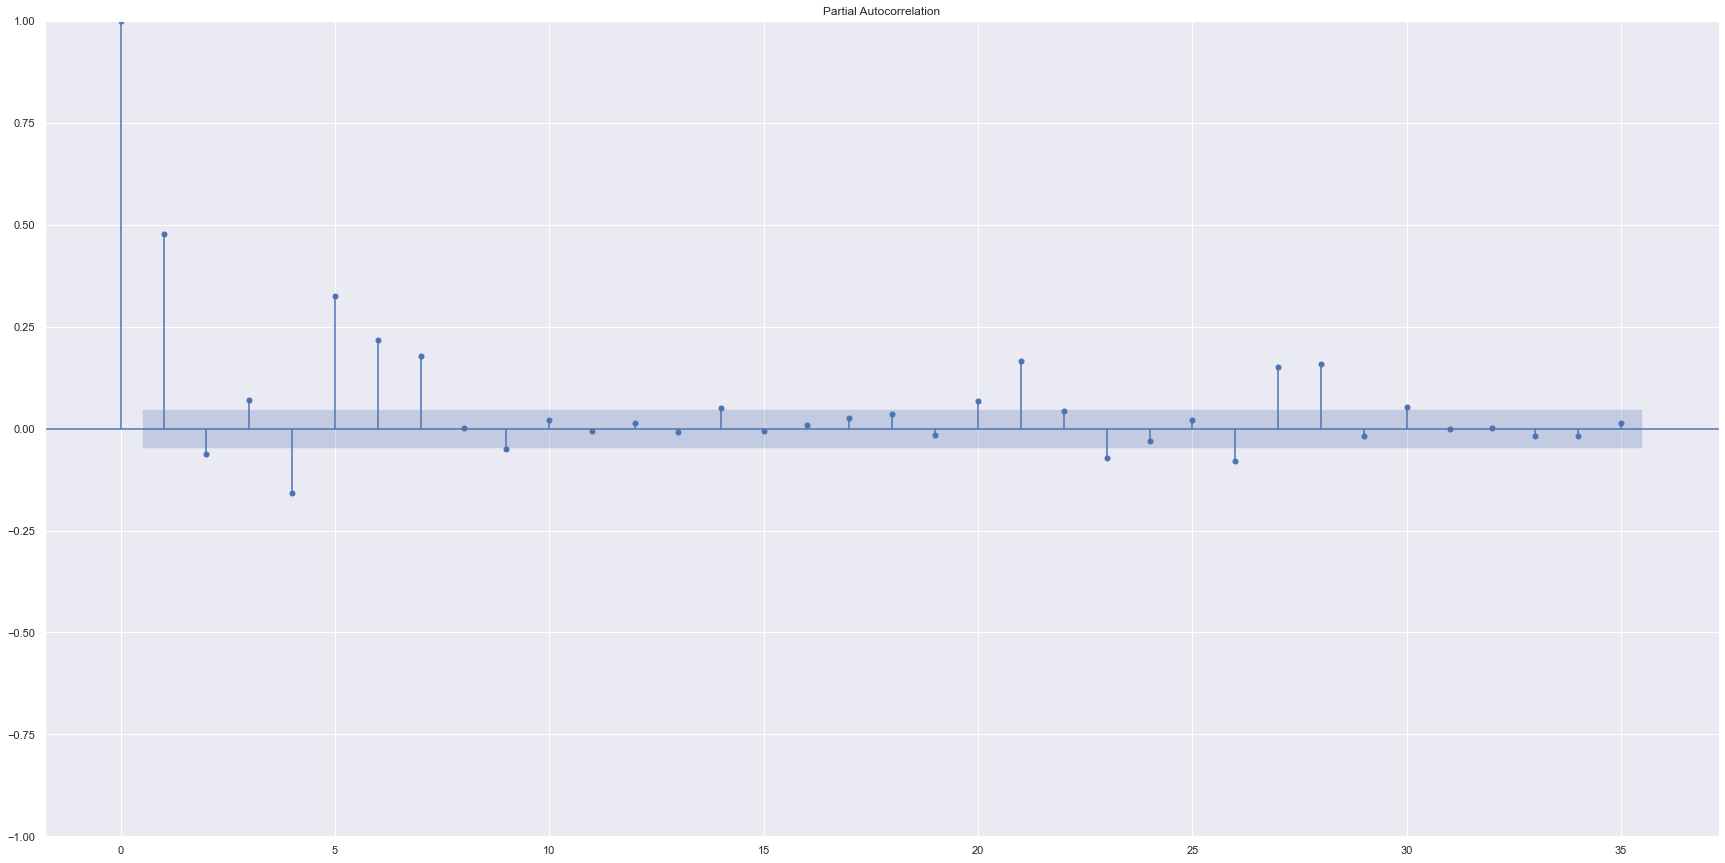

In [35]:
f.plot_pacf(train_only=True,lags=35)
plt.show()

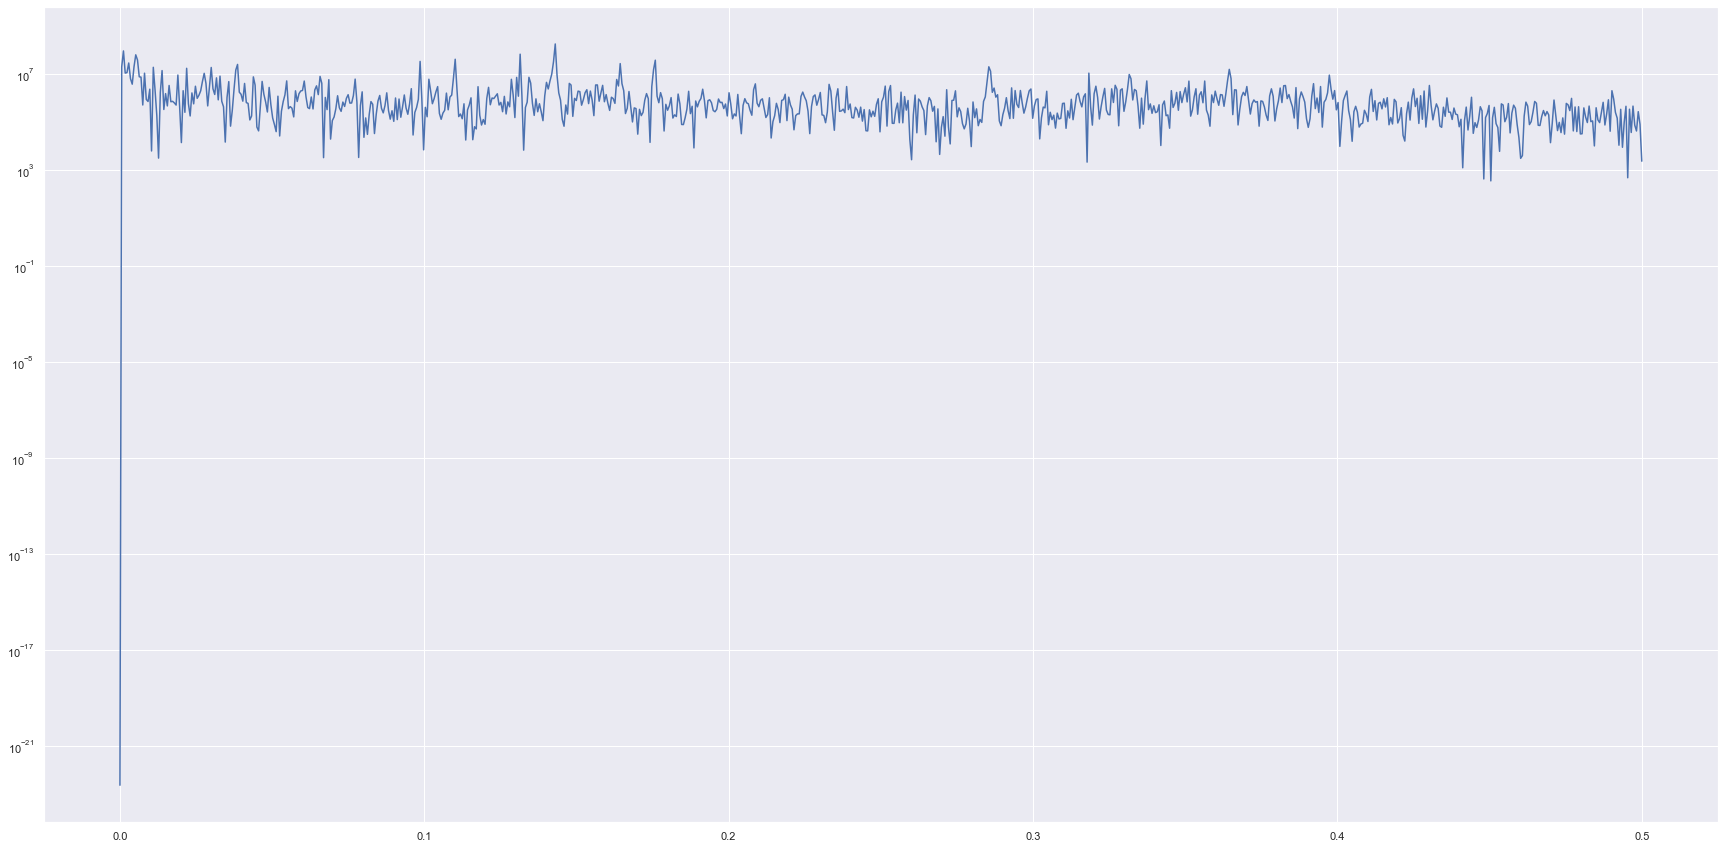

In [36]:
a, b = f.plot_periodogram(train_only=True)
plt.semilogy(a, b)
plt.show()

In [37]:
#There might be some drift in the data.
# f.seasonal_decompose(train_only=True).plot()
# plt.show()

In [38]:
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: -5.03
the p-value is 0.0000
the series is stationary
----------------------------------------------------------------------------------------------------


In [39]:
f.generate_future_dates(60) # forecast horizon
f.set_validation_length(60) # validation set length for tuning hyperparameters
f.add_ar_terms(7) # 7 dep variable lags
f.add_AR_terms((5,7)) # 5 weekly seasonaly dep variable lags
f.add_seasonal_regressors(
    'month',
    'quarter',
    'week',
    'dayofyear',
    raw=False,
    sincos=True) # wave-form seasonality
f.add_seasonal_regressors(
    'dayofweek',
    'week',
    raw=False,
    dummy=True,
    drop_first=True
) # dummy variable seasonality
f.add_seasonal_regressors('year') # yearly trend
f

Forecaster(
    DateStartActuals=2014-01-10T00:00:00.000000000
    DateEndActuals=2020-12-08T00:00:00.000000000
    Freq=None
    N_actuals=2167
    ForecastLength=60
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR14', 'AR21', 'AR28', 'AR35', 'monthsin', 'monthcos', 'quartersin', 'quartercos', 'weeksin', 'weekcos', 'dayofyearsin', 'dayofyearcos', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'week_10', 'week_11', 'week_12', 'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18', 'week_19', 'week_2', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_3', 'week_30', 'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_4', 'week_40', 'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 'week_5', 'week_50', 'week_51', 'week_52', 'week_53', 'week_6', 'week_7', '

In [40]:
f.set_estimator('prophet')
f.manual_forecast()

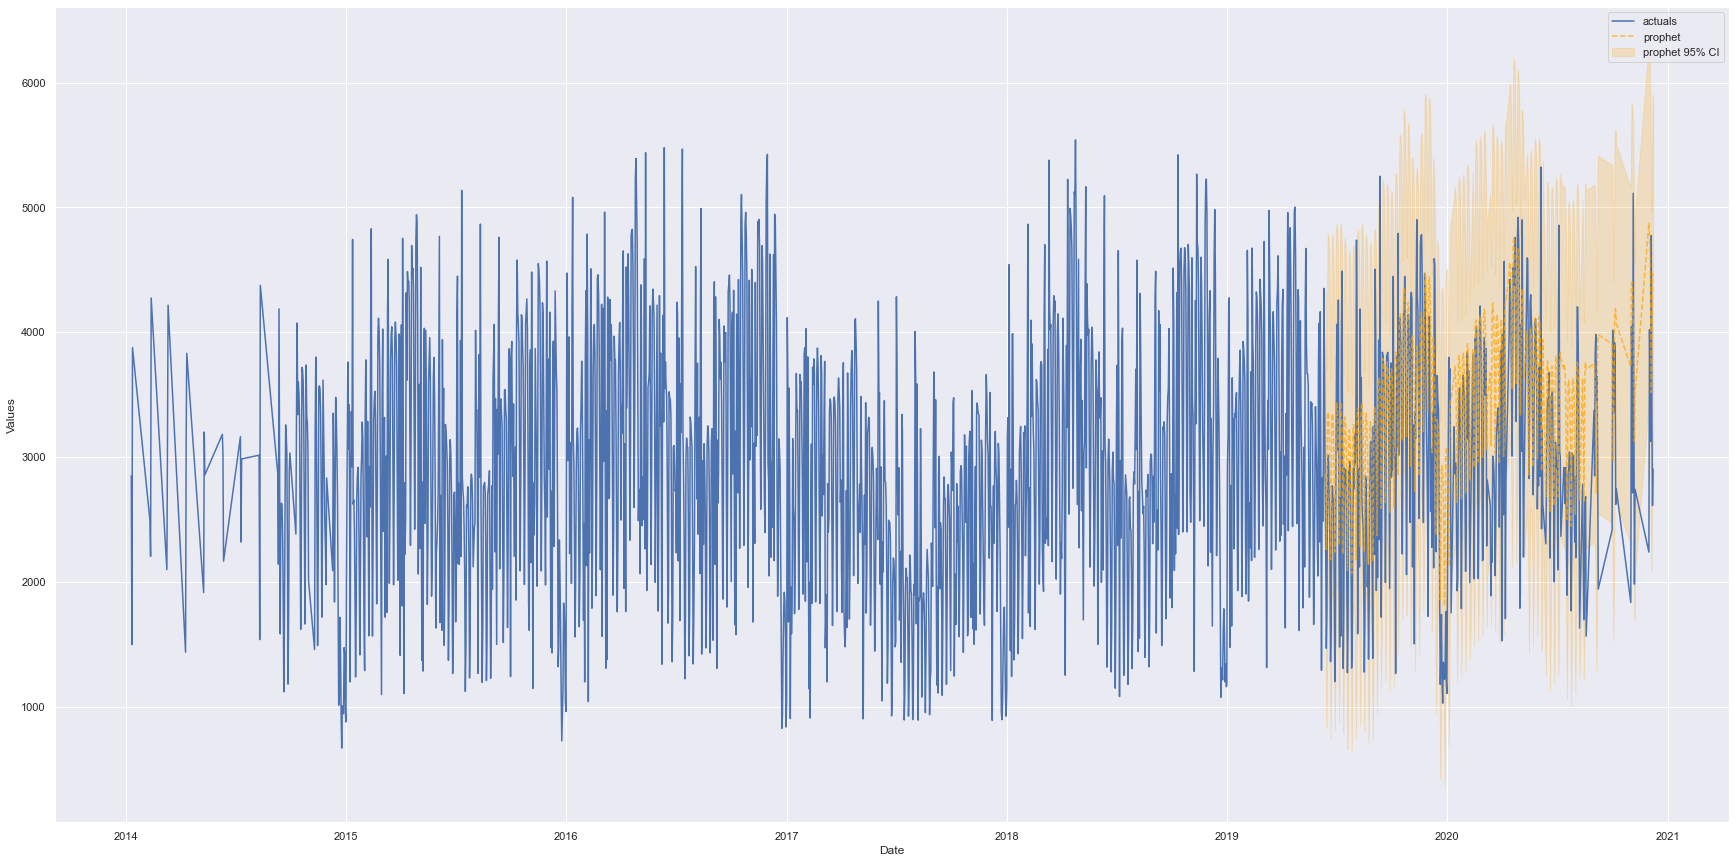

In [41]:
f.plot_test_set(ci=True,models='prophet')
plt.show()